<a href="https://colab.research.google.com/github/orchidObsessed/sbx_osu_cs4783/blob/main/Naive_Bayes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Naive Bayes Implementation

In [89]:
# Import 3rd-party libraries
from sklearn import tree, neighbors
import pandas as pd # For reading from .xslx

# Import 1st-party libraries
from math import floor

# Mount to Drive
from google.colab import drive
drive.mount("/content/drive", force_remount=True) # Forcing remount just in case

# Set up training & testing datasets
train_pdframe = pd.read_excel("/content/drive/MyDrive/Asssignment4_Data.xlsx", sheet_name="Train", header=None, names=["nbed", "nbath", "nroom", "ngarage", "age", "land", "living", "price", "constype"], skiprows=1, usecols="B:J")
train_pdframe = train_pdframe.to_dict('records')

test_pdframe = pd.read_excel("/content/drive/MyDrive/Asssignment4_Data.xlsx", sheet_name="Test", header=None, names=["nbed", "nbath", "nroom", "ngarage", "age", "land", "living", "price", "constype"], skiprows=1, usecols="B:J")
test_pdframe = test_pdframe.to_dict('records')

Mounted at /content/drive


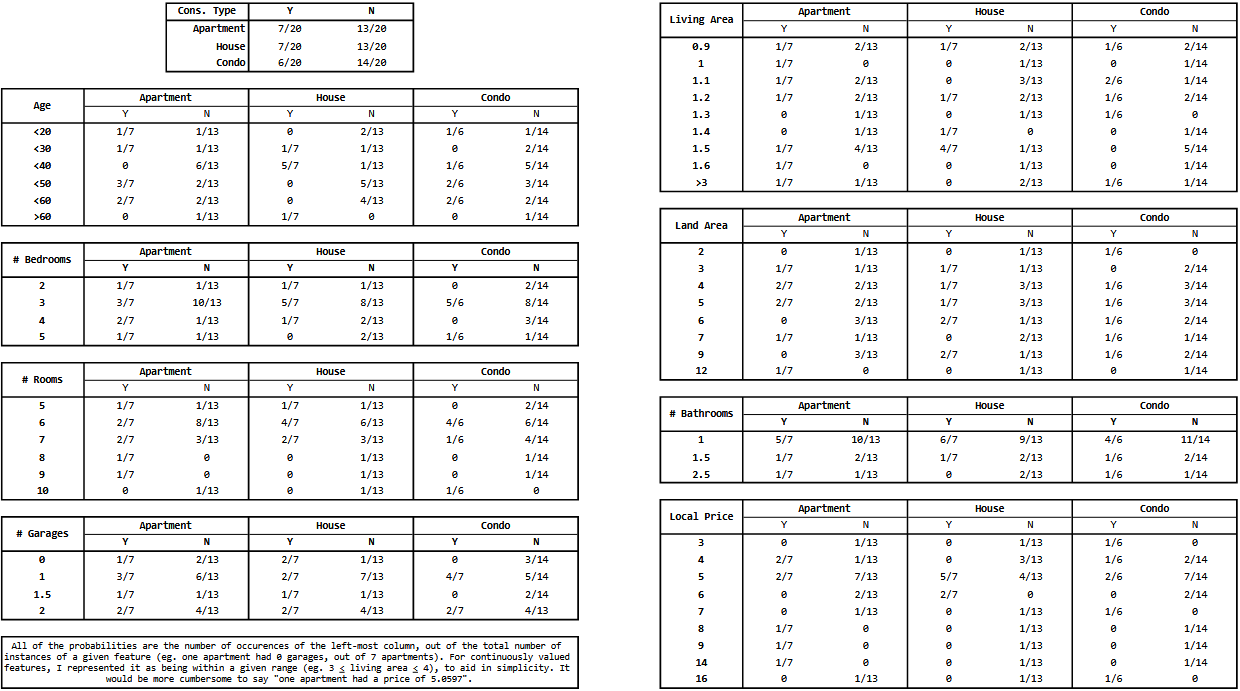

In [32]:
prob_y_given_apartment = {"nbed":[1/7, 1/7, 0, 3/7, 2/7, 0], "nroom":[1/7, 2/7, 2/7, 1/7, 1/7, 0], "ngarage":[1/7, 3/7, 1/7, 2/7], "nbath":[5/7, 1/7, 1/7], "age":[1/7, 1/7, 0, 3/7, 2/7, 0], "living":[1/7, 1/7, 1/7, 1/7, 0, 0, 1/7, 1/7, 1/7], "land":[0, 1/7, 2/7, 2/7, 0, 1/7, 0, 1/7], "price":[0, 2/7, 2/7, 0, 0, 1/7, 1/7, 1/7, 0]}
prob_y_given_condo = {"nbed":[0, 5/6, 0, 1/6], "nroom":[0, 4/6, 1/6, 0, 0, 1/6], "ngarage":[0, 4/7, 0, 2/7], "nbath":[4/6, 1/6, 1/6], "age":[1/6, 0, 1/6, 2/6, 2/6, 0], "living":[1/6, 0, 2/6, 1/6, 1/6, 0, 0, 0, 1/6], "land":[1/6, 0, 1/6, 1/6, 1/6, 1/6, 1/6, 0], "price":[1/6, 1/6, 2/6, 0, 1/6, 0, 0, 0, 1/6]}
prob_y_given_house = {"nbed":[1/7, 5/7, 1/7, 0], "nroom":[1/7, 4/7, 2/7, 0, 0, 0], "ngarage":[2/7, 2/7, 1/7, 2/7], "nbath":[6/7, 1/7, 0], "age":[0, 1/7, 5/7, 0, 0, 1/7], "living":[1/7, 0, 0, 1/7, 0, 1/7, 4/7, 0, 0], "land":[0, 1/7, 1/7, 1/7, 2/7, 0, 2/7, 0], "price":[0, 0, 5/7, 2/7, 0, 0, 0, 0, 0]}

typetable = {"apartment":prob_y_given_apartment, "condo":prob_y_given_condo, "house":prob_y_given_house}

def prob_selector(category: str, feature: str, v: float, converse: bool = False) -> float:
  """
  Select the probability P(feature_v|category_yes).

  If optional parameter `converse` is chosen, will instead return the probability P(feature_v|category_no).
  """
  # Step 0: Typechecking
  assert category in typetable.keys(), f"{category} is not a construction type!"
  assert feature in typetable[category].keys(), f"{feature} is not a feature!"

  # Step 1: Lookup index given feature value
  i = None
  try:
    if feature == "nbed":
      assert 2 <= v and v <= 5, f"{v} out of range for feature {feature}!"
      i = v - 2
    elif feature == "nroom":
      assert 5 <= v and v <= 10, f"{v} out of range for feature {feature}!"
      i = v - 5
    elif feature == "ngarage":
      assert v in [0, 1, 1.5, 2], f"{v} out of range for feature {feature}!"
      i = [0, 1, 1.5, 2].index(v)
    elif feature == "nbath":
      assert v in [1, 1.5, 2.5], f"{v} out of range for feature {feature}!"
      i = [1, 1.5, 2.5].index(v)
    elif feature == "age":
      assert 10 <= v and v < 70, f"{v} out of range for feature {feature}!"
      if v < 20: i = 0
      elif v < 30: i = 1
      elif v < 40: i = 2
      elif v < 50: i = 3
      elif v < 60: i = 4
      elif v > 60: i = 5
      else: raise AssertionError(f"{v} out of range for feature {feature}!")
    elif feature == "living":
      assert 0.9 <= v and not (1.7 <= v and v < 3), f"{v} out of range for feature {feature}!"
      if v < 1: i = 0
      elif v < 1.1: i = 1
      elif v < 1.2: i = 2
      elif v < 1.3: i = 3
      elif v < 1.4: i = 4
      elif v < 1.5: i = 5
      elif v < 1.6: i = 6
      elif v < 1.7: i = 7
      elif v > 3: i = 8
    elif feature == "land":
      assert v >= 2 and v < 13 and floor(v) != 8, f"{v} out of range for feature {feature}!"
      if v < 3: i = 0
      elif v < 4: i = 1
      elif v < 5: i = 2
      elif v < 6: i = 3
      elif v < 7: i = 4
      elif v < 8: i = 5
      elif v < 10: i = 6
      elif v < 13: i = 7
    elif feature == "price":
      assert v >=3 and v < 17 and floor(v) not in [10, 11, 12, 13, 15], f"{v} out of range for feature {feature}!"
      if v < 4: i = 0
      elif v < 5: i = 1
      elif v < 6: i = 2
      elif v < 7: i = 3
      elif v < 8: i = 4
      elif v < 9: i = 5
      elif v < 10: i = 6
      elif v < 15: i = 7
      elif v < 17: i = 8
  except AssertionError as e:
    # print(f"{e}, returning P(x)=0")
    return 0

  i = int(i) # Catch weirdness from PD Dframe

  if converse:
    if category == "apartment":
      n_house = typetable["house"][feature][i]*7
      n_condo = typetable["condo"][feature][i]*6
      return (n_house + n_condo) / 13
    elif category == "house":
      n_apartment = typetable["apartment"][feature][i]*7
      n_condo = typetable["condo"][feature][i]*6
      return (n_apartment + n_condo) / 13
    elif category == "condo":
      n_apartment = typetable["apartment"][feature][i]*7
      n_house = typetable["house"][feature][i]*7
      return (n_apartment + n_house) / 14

  return typetable[category][feature][i]

In [25]:
def naive_bayes_prob(x: tuple) -> tuple:
  """
  Given a tuple of {feature:v}, return a tuple of probabilities for each construction type.
  """
  types = ["apartment", "house", "condo"]
  features = ["nbed", "nbath", "nroom", "ngarage", "age", "land", "living", "price"]
  probs = {}

  for t in types:
    # Set base value to probability of feature
    if t == "condo": p_y, p_n = 6/20, 14/20
    else: p_y, p_n = 7/20, 13/20

    # MAP rule
    for f in features:
      nabla_y, nabla_n = prob_selector(t, f, x[f]), prob_selector(t, f, x[f], True)
      # We check for zero, because once we multiply by zero, we can never come back up from it.
      if nabla_y: p_y *= nabla_y
      if nabla_n: p_n *= nabla_n
    
    # Normalize
    try: p_y = p_y / (p_y + p_n)
    except ZeroDivisionError: p_y = 0
    p_n = 1 - p_y

    # Save for returning
    probs[t] = [p_y, p_n]

  return probs

In [24]:
def map_final_classification(x: tuple) -> str:
  """
  Given a tuple of conditional probabilities for each class, return the most likely class.
  """
  # Step 1: only choose from those where p_y > p_n
  possibilities = []
  for category, prob_pair in zip(list(x.keys()), list(x.values())):
    if prob_pair[0] > prob_pair[1]:
      possibilities.append(category)

  # Step 2: Find the greatest delta, and choose it
  deltas = []
  for category in possibilities:
    deltas.append(abs(x[category][0] - x[category][1]))
  return possibilities[deltas.index(max(deltas))]

In [23]:
def print_sample_probs(x: tuple, i: int) -> None:
  """
  Just a wrapper function to nicely print results for a sample.
  """
  x_prob = naive_bayes_prob(x)
  x_eval = map_final_classification(x_prob)

  print(f"House ID {i}\nProbabilities: {x_prob}\nFinal classification: {x_eval}\n---")
  return

In [ ]:
# Test!
for i in range(24, 29):
  print_sample_probs(test_pdframe[i-24], i)


# Decision Tree Implementation

Reformat the datasets so that they're compatible with SciKit DecisionTreeClassifier (reformat from list[dict] to array, and reformat labels from strings (construction type) to int)

In [ ]:
# Constype str-int cheatsheet
cheatsheet = ["Apartment", "Condo", "House"]

# Build training arrays
train_data = []
train_labels = []

for item in train_pdframe:
  templist = []
  for key in item.keys():
    if key == "constype": train_labels.append(item[key])
    else: templist.append(item[key])
  train_data.append(templist)

for i in range(len(train_labels)):
  train_labels[i] = cheatsheet.index(train_labels[i])

# Build testing arrays
test_data = []
test_labels = []

for item in test_pdframe:
  templist = []
  for key in item.keys():
    if key == "constype": test_labels.append(item[key])
    else: templist.append(item[key])
  test_data.append(templist)

for i in range(len(test_labels)):
  test_labels[i] = cheatsheet.index(test_labels[i])

Make & test the decision tree using default parameters.

In [ ]:
# Make, train & test the tree
test_tree = tree.DecisionTreeClassifier()
test_tree = test_tree.fit(train_data, train_labels)

# Round 1 - Training set
acc_counter = 0
for point, label in zip(train_data, train_labels):
  pred = test_tree.predict([point])
  pred = int(pred)
  if pred == label:
    acc_counter += 1
  else:
    print(f"Misclassified {cheatsheet[label]} as a(n) {cheatsheet[pred]}")
print(f"Accuracy on training set: {acc_counter}/{len(train_labels)} -> {(acc_counter/len(train_labels))*100}%\n---")

# Round 2 - Testing set
acc_counter = 0
for point, label in zip(test_data, test_labels):
  pred = test_tree.predict([point])
  pred = int(pred)
  if pred == label:
    acc_counter += 1
  else:
    print(f"Misclassified {cheatsheet[label]} as a(n) {cheatsheet[pred]}")
print(f"Accuracy on testing set: {acc_counter}/{len(test_labels)} -> {(acc_counter/len(test_labels))*100}%")

Make & test trees of varying max depths. First is shallow tree, second is deep tree (depth limit is way too high here, since tree can't actually be 10 deep), and third is the best depth in regards to testing accuracy

In [ ]:
# Remake tree using low depth limit

shallow_tree = tree.DecisionTreeClassifier(max_depth=1)
shallow_tree = shallow_tree.fit(train_data, train_labels)

# Round 1 - Training set
acc_counter = 0
for point, label in zip(train_data, train_labels):
  pred = shallow_tree.predict([point])
  pred = int(pred)
  if pred == label:
    acc_counter += 1
  else:
    print(f"Misclassified {cheatsheet[label]} as a(n) {cheatsheet[pred]}")
print(f"Accuracy on training set: {acc_counter}/{len(train_labels)} -> {(acc_counter/len(train_labels))*100}%\n---")

# Round 2 - Testing set
acc_counter = 0
for point, label in zip(test_data, test_labels):
  pred = shallow_tree.predict([point])
  pred = int(pred)
  if pred == label:
    acc_counter += 1
  else:
    print(f"Misclassified {cheatsheet[label]} as a(n) {cheatsheet[pred]}")
print(f"Accuracy on testing set: {acc_counter}/{len(test_labels)} -> {(acc_counter/len(test_labels))*100}%")

In [ ]:
# Remake tree using a high depth limit

deep_tree = tree.DecisionTreeClassifier(max_depth=10)
deep_tree = deep_tree.fit(train_data, train_labels)

# Round 1 - Training set
acc_counter = 0
for point, label in zip(train_data, train_labels):
  pred = deep_tree.predict([point])
  pred = int(pred)
  if pred == label:
    acc_counter += 1
  else:
    print(f"Misclassified {cheatsheet[label]} as a(n) {cheatsheet[pred]}")
print(f"Accuracy on training set: {acc_counter}/{len(train_labels)} -> {(acc_counter/len(train_labels))*100}%\n---")

# Round 2 - Testing set
acc_counter = 0
for point, label in zip(test_data, test_labels):
  pred = deep_tree.predict([point])
  pred = int(pred)
  if pred == label:
    acc_counter += 1
  else:
    print(f"Misclassified {cheatsheet[label]} as a(n) {cheatsheet[pred]}")
print(f"Accuracy on testing set: {acc_counter}/{len(test_labels)} -> {(acc_counter/len(test_labels))*100}%")

In [ ]:
# Remake tree using best-depth FOR TESTING DATA

goldilocks_tree = tree.DecisionTreeClassifier(max_depth=2)
goldilocks_tree = goldilocks_tree.fit(train_data, train_labels)

# Round 1 - Training set
acc_counter = 0
for point, label in zip(train_data, train_labels):
  pred = goldilocks_tree.predict([point])
  pred = int(pred)
  if pred == label:
    acc_counter += 1
  else:
    print(f"Misclassified {cheatsheet[label]} as a(n) {cheatsheet[pred]}")
print(f"Accuracy on training set: {acc_counter}/{len(train_labels)} -> {(acc_counter/len(train_labels))*100}%\n---")

# Round 2 - Testing set
acc_counter = 0
for point, label in zip(test_data, test_labels):
  pred = goldilocks_tree.predict([point])
  pred = int(pred)
  if pred == label:
    acc_counter += 1
  else:
    print(f"Misclassified {cheatsheet[label]} as a(n) {cheatsheet[pred]}")
print(f"Accuracy on testing set: {acc_counter}/{len(test_labels)} -> {(acc_counter/len(test_labels))*100}%")

Visualize the resulting tree

In [ ]:
# Visualizing the goldilocks tree here.

tree.plot_tree(goldilocks_tree)

# K-Nearest Neighbor Implementation

Reformat data from Pandas Dataframe to regular arrays. This cell is identical to the first cell in the Decision Tree Implementation section.

In [88]:
# Constype str-int cheatsheet
cheatsheet = ["Apartment", "Condo", "House"]

# Build training arrays
train_data = []
train_labels = []

for item in train_pdframe:
  templist = []
  for key in item.keys():
    if key == "constype": train_labels.append(item[key])
    else: templist.append(item[key])
  train_data.append(templist)

for i in range(len(train_labels)):
  train_labels[i] = cheatsheet.index(train_labels[i])

# Build testing arrays
test_data = []
test_labels = []

for item in test_pdframe:
  templist = []
  for key in item.keys():
    if key == "constype": test_labels.append(item[key])
    else: templist.append(item[key])
  test_data.append(templist)

for i in range(len(test_labels)):
  test_labels[i] = cheatsheet.index(test_labels[i])

Build and test 5 different k-nearest neighbor models, using k=1 through k=5.

In [ ]:
# Using SciKit Learn's neighbor.KNeighborsClassifier

for i in range(1, 6):
  k_classifier = neighbors.KNeighborsClassifier(n_neighbors=i)
  k_classifier.fit(train_data, train_labels)

  # Round 1 - Training set
  train_acc = 0
  for point, label in zip(train_data, train_labels):
    pred = k_classifier.predict([point])
    pred = int(pred)
    if pred == label: train_acc += 1
  train_acc /= len(train_labels)
  train_acc *= 100

  # Round 2 - Testing set
  test_acc = 0
  for point, label in zip(test_data, test_labels):
    pred = k_classifier.predict([point])
    pred = int(pred)
    if pred == label: test_acc += 1
  test_acc /= len(test_labels)
  test_acc *= 100

  print(f"With K={i} | Train accuracy: {train_acc}% | Test accuracy: {test_acc}%")
